In [2]:
import json
import pickle
from quick_draw.utils import project_dir
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Read class labels

In [13]:
with open(project_dir('data/evaluation/labels.json')) as f:
     labels_map = json.load(f)
     
id2label = list(range(0, len(labels_map)))
for label, label_id in labels_map.items():
    id2label[label_id] = label

## Read bitmaps from TFRecords

In [46]:
from quick_draw.tfrecords.read_tfrecords import read_bitmaps

# evaluation TFRecords
eval_file = project_dir('data/evaluation/file_1.tfrecords')
bitmaps = read_bitmaps(eval_file)

len(bitmaps)

10000


20000


30000


40000


50000


50250

In [58]:
# submission TFRecords
submission_file = project_dir('data/submission/test_simplified.tfrecords')
submission_bitmaps = read_bitmaps(submission_file)

len(submission_bitmaps)

6009

## Read evaluation data predictions

In [5]:
with open(project_dir('data/evaluation/predictions.pickle'), 'rb') as f:
    predictions = pickle.load(f)

#predictions[0]

## Accuracy and MAP 3

In [44]:
from quick_draw.average_precision import mapk


classes = [{
    'correct': [],
    'misclassified': [],
    'predicted': [],
} for i in range(0, len(labels_map))]

correct_predictions = 0
top3_predictions = []
for image_id, ((_, label_id), prediction) in enumerate(zip(bitmaps, predictions)):
    # top 3 labels
    sorted_pred = sorted([(i, probability) for i, probability in enumerate(prediction['probabilities'])], 
                         key=lambda x: x[1], reverse=True)
    top3_labels_ids = [i for i, _ in sorted_pred[:3]]
    top3_predictions.append(top3_labels_ids)

    predicted_label_id = prediction['class']
    correct = (predicted_label_id == label_id)

    if correct:
        correct_predictions += 1
    
    if correct:
        classes[label_id]['correct'].append((image_id, label_id))
    else:
        classes[label_id]['misclassified'].append((image_id, predicted_label_id))
        classes[predicted_label_id]['predicted'].append((image_id, label_id))

ground_truth = [[label_id] for _, label_id in bitmaps]

map3 = mapk(ground_truth, top3_predictions)

accuracy = correct_predictions / len(predictions)

print('Accuracy: %.04f' % accuracy)
print('Map3: %.04f' % map3)

Accuracy: 0.7654
Map3: 0.8275


## Plot examples

In [63]:
def plot_images(records):
    num_examples = len(records)
    columns = 10
    rows = num_examples // columns + 1
    plt.figure(figsize=(columns * 2, rows * 2.3))
    for i, (image, label_id) in enumerate(records):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(1 - image.reshape((28, 28)), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if label_id != -1:
            plt.title(id2label[label_id])
    
    plt.show()


def plot_class_predictions(class_info, limit=10):
    for title in ['correct', 'misclassified', 'predicted']:
        image_records = []
        for image_id, predicted_label_id in class_info[title][:limit]:
            image_records.append((bitmaps[image_id][0], predicted_label_id))
            
        print(title)
        plot_images(image_records)

correct


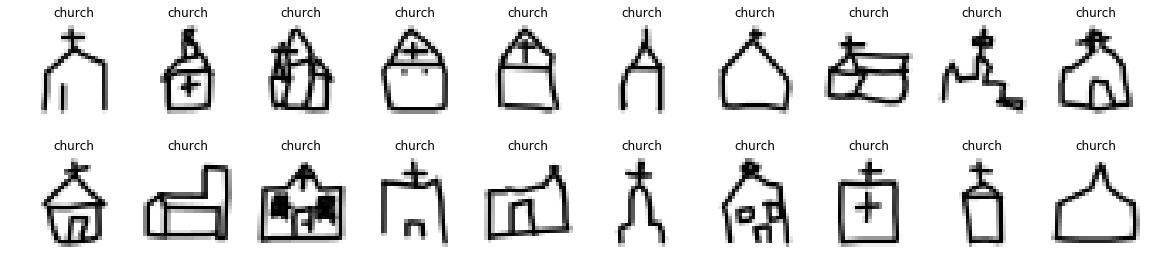

misclassified


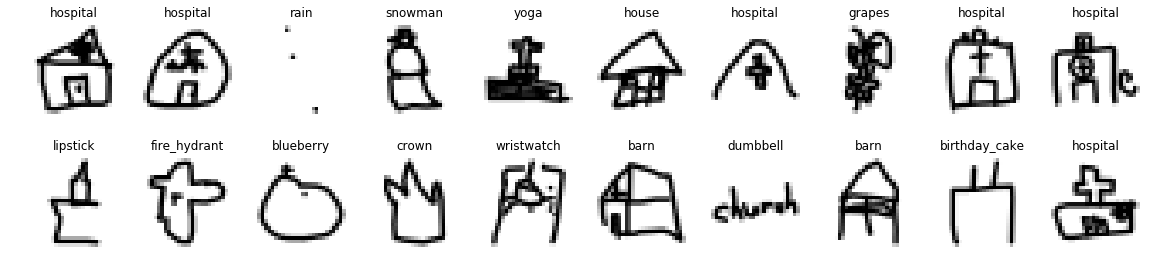

predicted


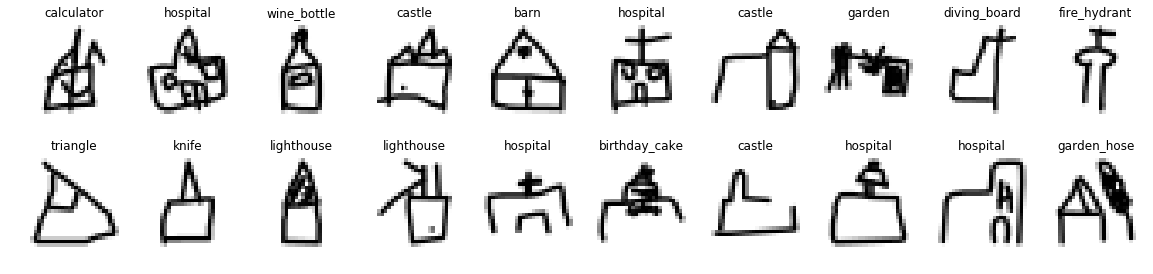

In [61]:
class_id = 6
plot_class_predictions(classes[class_id], 20)

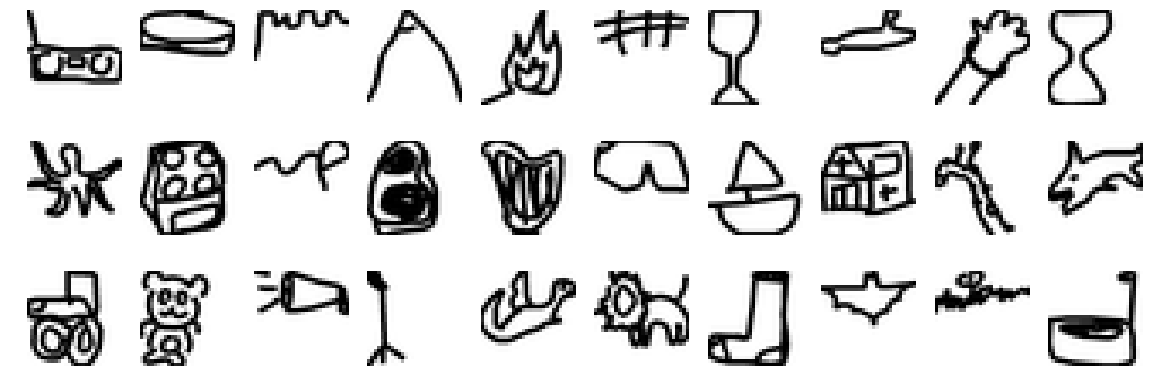

In [64]:
plot_images(submission_bitmaps[:30])